<a href="https://colab.research.google.com/github/gerald-wambui/RentIn/blob/main/AppleDiseaseDetectionGe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


In [5]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [7]:
# import system libs

import time
import shutil
import pathlib
import itertools

In [8]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [9]:
# Function to generate data paths with labels
def split_df(csv_dir):
    '''
    This function take csv file and split it into train, valid, and test
    '''

    df = pd.read_csv(csv_dir)

    # train dataframe
    train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

    # valid and test dataframe
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

    return train_df, valid_df, test_df

In [10]:
def create_gens(train_df, valid_df, test_df, batch_size):

    ''' This function takes train, validation, and test dataframe and fit them into image data generator, because model takes
        data from image data generator.
        Image data generator converts images into tensors.
        Check your variables'''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)
    train_dir = '/content/train_images'
    test_dir = '/content/test_images'
    fpath_col = 'image'
    label_col = 'labels'

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df,
                                           directory= train_dir,
                                            x_col= fpath_col,
                                            y_col= label_col,
                                            target_size= img_size,
                                            class_mode= 'categorical',
                                            color_mode= color,
                                            shuffle= True,
                                            batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, directory= train_dir, x_col= fpath_col, y_col= label_col, target_size= img_size,
                                            class_mode= 'categorical', color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, directory= train_dir, x_col= fpath_col, y_col= label_col, target_size= img_size,
                                            class_mode= 'categorical', color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [11]:
def show_images(df, data_path):
    '''
    This function take the data generator and show sample of the images
    '''

    sample_df = df.sample(16)
    image_names = sample_df["image"].values
    labels = sample_df["labels"].values
    plt.figure(figsize=(16, 12))

    for image_ind, (image_name, label) in enumerate(zip(image_names, labels)):
        plt.subplot(4, 4, image_ind + 1)
        image = cv2.imread(os.path.join(data_path, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    plt.show()

In [12]:
def plot_labels(df):
    '''
    This function take df and plot labels value counts
    '''

    plt.figure(figsize= (12, 8))
    labels = sns.barplot(x= df.labels.value_counts().index, y= df.labels.value_counts())
    for item in labels.get_xticklabels():
        item.set_rotation(45)

In [13]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

 # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)

def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')

def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training
        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')



In [14]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()



In [15]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)


	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [2]:
!kaggle competitions download -c plant-pathology-2021-fgvc8

100% 14.9G/14.9G [03:04<00:00, 109MB/s]
100% 14.9G/14.9G [03:04<00:00, 86.4MB/s]


In [3]:
!unzip \*.zip


Streaming output truncated to the last 5000 lines.
  inflating: train_images/e00c97b2de4749ce.jpg  
  inflating: train_images/e00df890cfe62736.jpg  
  inflating: train_images/e00ed0bf43a87f25.jpg  
  inflating: train_images/e00f759d65d52887.jpg  
  inflating: train_images/e00f934d9e50ad5b.jpg  
  inflating: train_images/e00fce341cb63da5.jpg  
  inflating: train_images/e010c7c35ecf3d1c.jpg  
  inflating: train_images/e01112939f783fec.jpg  
  inflating: train_images/e01592da4d71b8be.jpg  
  inflating: train_images/e0189acaf8cf80fd.jpg  
  inflating: train_images/e0189e4999bdd0fa.jpg  
  inflating: train_images/e01ae16d4a759cb5.jpg  
  inflating: train_images/e01dc39ccb2b4ccb.jpg  
  inflating: train_images/e01e42d90c66f3f3.jpg  
  inflating: train_images/e01e870bec65f40f.jpg  
  inflating: train_images/e01f17e0187fb80f.jpg  
  inflating: train_images/e01f503cb752e6c5.jpg  
  inflating: train_images/e024b69a784e9fc3.jpg  
  inflating: train_images/e026b4c23c9fcfc4.jpg  
  inflating: train

In [16]:
csv_dir = input('Enter CSV file for training')
train_path = '/content/train_images'
try:
    # Get splitted data
    train_df, valid_df, test_df = split_df(csv_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except Exception:
    print('Invalid Input')

Enter CSV file for training/content/train.csv
Found 13042 validated image filenames belonging to 12 classes.
Found 2795 validated image filenames belonging to 12 classes.
Found 2795 validated image filenames belonging to 12 classes.


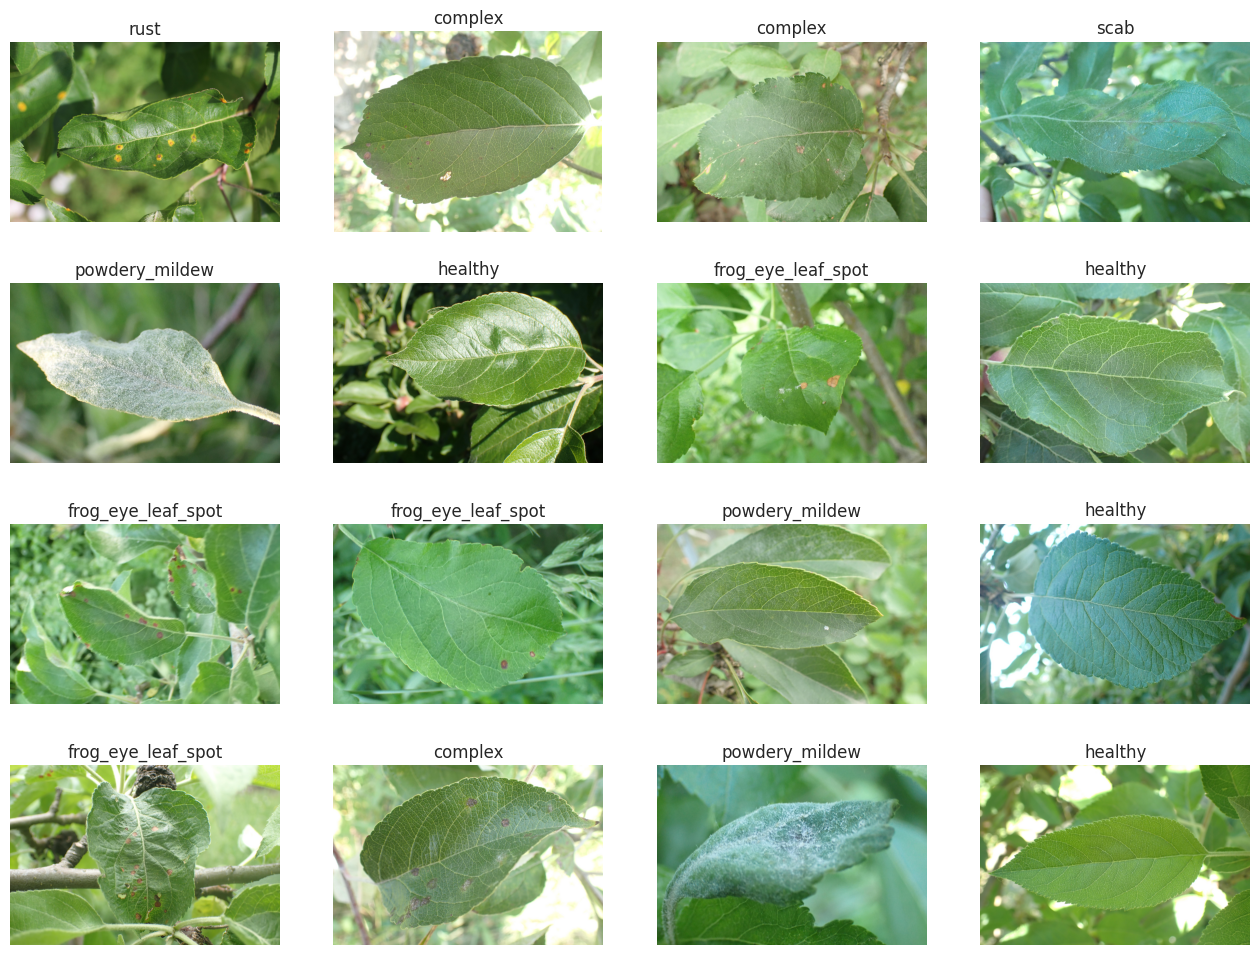

In [17]:
show_images(train_df, train_path)

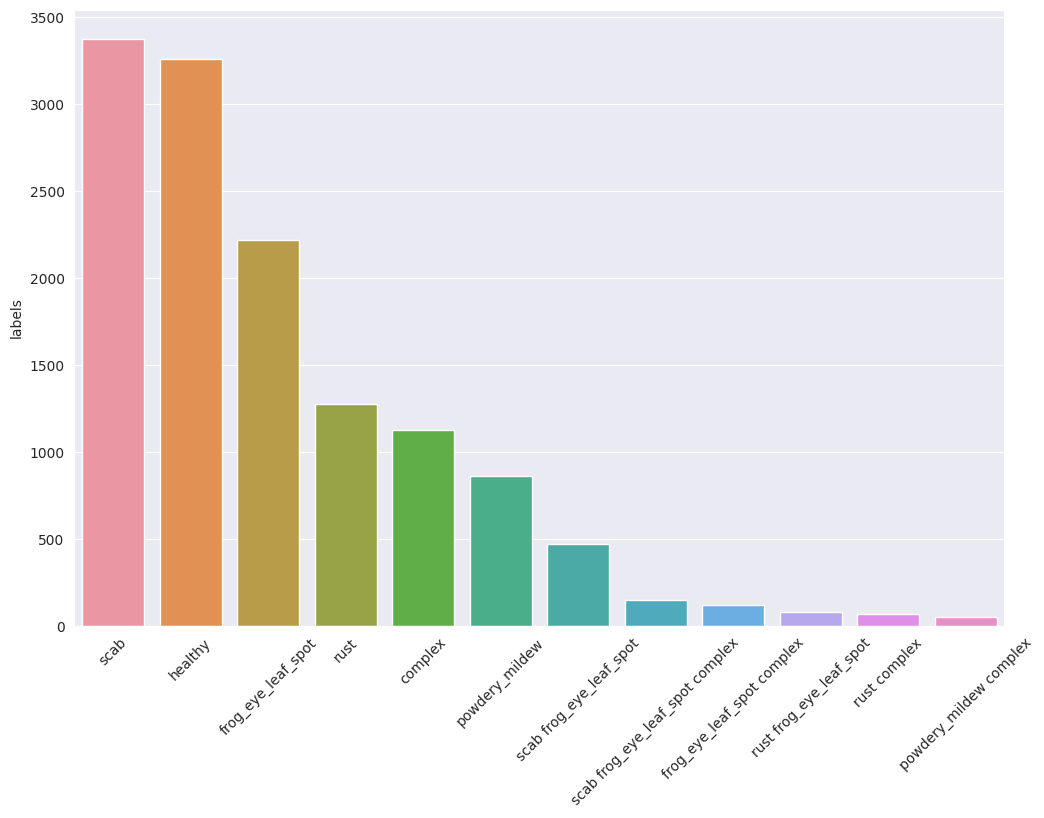

In [18]:
plot_labels(train_df)

In [19]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


In [20]:
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')


43941136/43941136 [==============================] - 0s 0us/step


In [21]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(64, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'sigmoid')
])


In [22]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                98368     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                780       
                                                                 
Total params: 10888827 (41.54 MB)
Trainable params: 1079

In [23]:
batch_size = 40   # set batch size for training
epochs = 10   # number of all epochs in training
patience = 2   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [24]:
history = model.fit(train_gen, epochs = epochs, verbose= 0,
                    validation_data = valid_gen, validation_steps = None, shuffle = False)

Epoch 1/10
327/327 [==============================] - 1128s 3s/step - loss: 2.8427 - accuracy: 0.7100 - val_loss: 1.9774 - val_accuracy: 0.8472
Epoch 2/10
327/327 [==============================] - 1062s 3s/step - loss: 1.7860 - accuracy: 0.8505 - val_loss: 1.4594 - val_accuracy: 0.8733
Epoch 3/10
327/327 [==============================] - 1013s 3s/step - loss: 1.3643 - accuracy: 0.8698 - val_loss: 1.2052 - val_accuracy: 0.8730
Epoch 4/10
327/327 [==============================] - 997s 3s/step - loss: 1.0884 - accuracy: 0.8861 - val_loss: 0.9915 - val_accuracy: 0.8773
Epoch 5/10
327/327 [==============================] - 1115s 3s/step - loss: 0.8998 - accuracy: 0.8973 - val_loss: 0.8810 - val_accuracy: 0.8834
Epoch 6/10
327/327 [==============================] - 1033s 3s/step - loss: 0.7539 - accuracy: 0.9082 - val_loss: 0.7795 - val_accuracy: 0.8852
Epoch 7/10
327/327 [==============================] - 1101s 3s/step - loss: 0.6392 - accuracy: 0.9157 - val_loss: 0.7009 - val_accuracy: 

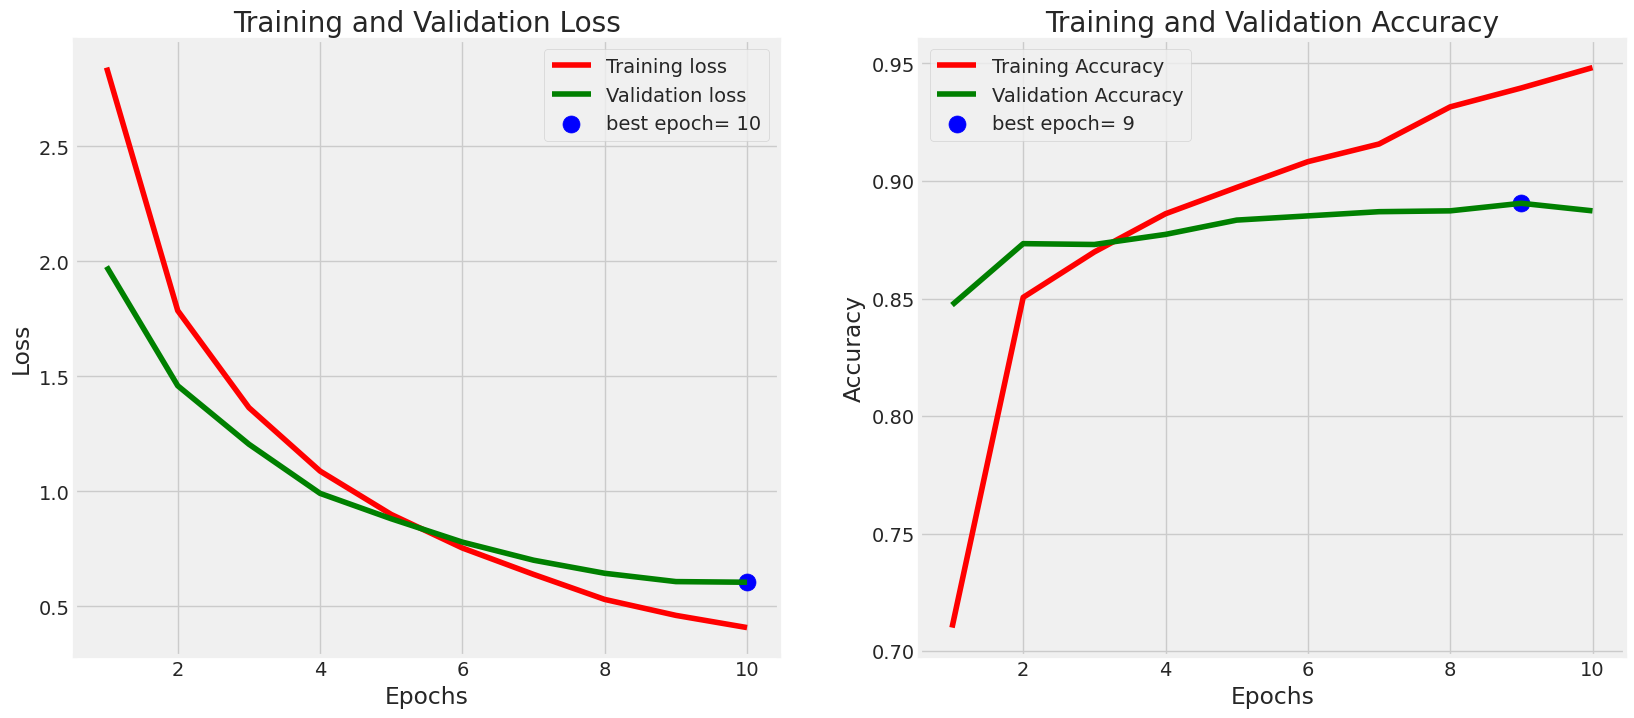

In [25]:
plot_training(history)

In [26]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

43/43 [==============================] - 171s 4s/step - loss: 0.6402 - accuracy: 0.8780
Train Loss:  0.27391374111175537
Train Accuracy:  0.984883725643158
--------------------
Validation Loss:  0.6058411598205566
Validation Accuracy:  0.8837209343910217
--------------------
Test Loss:  0.6402103900909424
Test Accuracy:  0.8779964447021484


In [27]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
# print(y_pred)

Confusion Matrix, Without Normalization
[[154  17   6   0   1   1  37   2   0  12  17   4]
 [ 12 458   1   0   1   0   2   0   0   5   4   1]
 [ 13   2   9   0   0   0   0   0   0   0   2   1]
 [  0   0   0 678   0   0   5   0   0   8   0   0]
 [  0   1   0   4 154   0   0   0   0   1   0   0]
 [  6   1   1   0   5   5   0   0   0   1   0   0]
 [  6   2   1   0   0   0 271   2   0   1   0   0]
 [  2   1   0   0   0   0   6   3   0   0   0   0]
 [  2   3   1   0   0   0  13   2   0   0   1   0]
 [  5   4   0  20   1   0   1   0   0 680   3   0]
 [ 44  12   1   0   0   0   1   0   0   6  39   2]
 [ 16   1   1   0   0   0   0   0   0   0   6   3]]
                                 precision    recall  f1-score   support

                        complex       0.59      0.61      0.60       251
             frog_eye_leaf_spot       0.91      0.95      0.93       484
     frog_eye_leaf_spot complex       0.43      0.33      0.38        27
                        healthy       0.97      0.98  

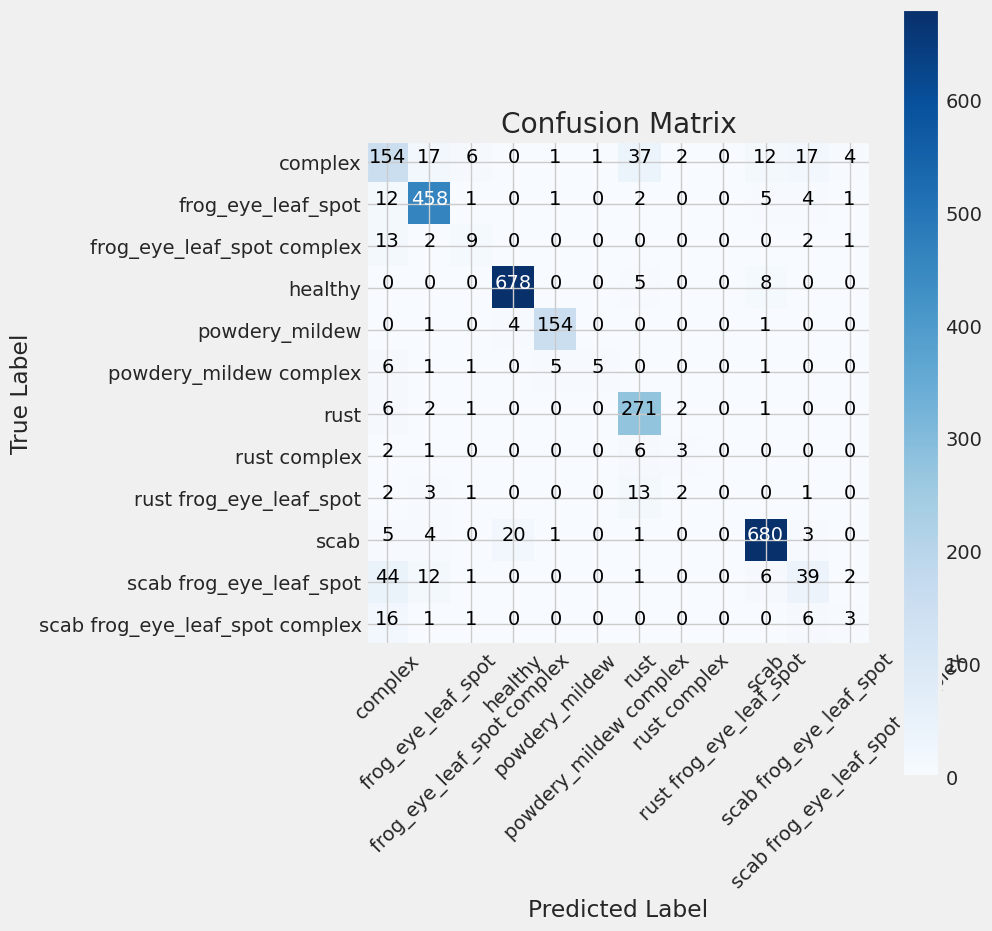

In [28]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [29]:
model_name = model.input_names[0][:-6]
subject = input('Enter Project Subject')
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

Enter Project SubjectAppleDiseaseDetectorGe
model was saved as efficientnetb3-AppleDiseaseDetectorGe-87.80.h5
weights were saved as efficientnetb3-AppleDiseaseDetectorGe-weights.h5


In [30]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as AppleDiseaseDetectorGe-class_dict.csv


In [31]:
!pip install tensorflow tensorflow-lite


ERROR: Could not find a version that satisfies the requirement tensorflow-lite (from versions: none)
ERROR: No matching distribution found for tensorflow-lite


In [37]:

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('gerald.tflite', 'wb') as f:
  f.write(tflite_model)

Exception ignored in: <function _xla_gc_callback at 0x7b852b13b490>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [36]:
tflite_model = tf.keras.models.load_model('efficientnetb3-AppleDiseaseDetectorGe-87.80.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
open("gerald.tflite", "wb").write(tflite_save)

# Load the TFLite model and allocate tensors. View details
interpreter = tf.lite.Interpreter(model_path="gerald.tflite")
print(interpreter.get_input_details())
print(interpreter.get_output_details())
print(interpreter.get_tensor_details())
interpreter.allocate_tensors()


[{'name': 'serving_default_efficientnetb3_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 783, 'shape': array([ 1, 12], dtype=int32), 'shape_signature': array([-1, 12], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'serving_default_efficientnetb3_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantizati

In [38]:
!tar -cz -f model.tar.gz --owner=0 --group=0 -C /tmp/export-gerald/

tar: Cowardly refusing to create an empty archive
Try 'tar --help' or 'tar --usage' for more information.


In [39]:
!tar -tf gerald.tar.gz

tar: gerald.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
